In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [5]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


cifar
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


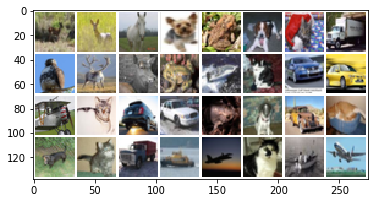

torch.Size([32, 3, 32, 32])


In [6]:
### LOAD DATA ###

batch_size = 32
dataset = 'cifar'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=batch_size)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))

plot_grid(sample)
print(sample_magnitudes.shape)

In [7]:
# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        ft = torch.rfft(data, 2, onesided=False)
        magn = torch.sqrt(torch.sum(ft**2, -1))
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [8]:
class ConvDiscriminatorSmall(nn.Module):
    def __init__(self, imsize=(1, 32, 32), s=64):
        super(ConvDiscriminatorSmall, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(imsize[0], s, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (s) x 16 x 16
            nn.Conv2d(s, s * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(s * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (s*2) x 8 x 8
            nn.Conv2d(s * 2, s * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(s * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (s*4) x 4 x 4
            nn.Conv2d(s * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

In [9]:
# Define Gen and Disc loss

#def gen_loss(disc_output_generated, gen_output, x):
#    reconstruction = torch.mean(torch.abs(x-gen_output))
#    adversarial = 0.5*torch.mean((1-disc_output_generated)**2)
#    return reconstruction + adversarial

def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

#def disc_loss(disc_output_real, disc_output_generated):
#    loss_real = 0.5*torch.mean((1-disc_output_real)**2)
#    loss_generated = 0.5*torch.mean((disc_output_generated)**2)
#    return loss_real+loss_generated

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [48]:
### Create new models ###

gen = models.ConvNet(imsize=(6, 32, 32), outsize=imsize, s=128)
disc = ConvDiscriminatorSmall(imsize=(6, 32, 32), s=128)

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 2048


In [49]:
# Set training parameters

history = []
g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)
lmd = 1e3 # loss signal

In [50]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

zm = torch.cat([torch.randn(*sample.shape).to(device), sample_magnitudes], dim=1)
gen_out = gen(zm)

xm = torch.cat([sample, sample_magnitudes], dim=1)
disc_output_real = disc(xm)
disc_output_generated = disc(torch.cat([gen_out, sample_magnitudes], dim=1))

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 293.64794921875
Discriminator initial loss: 0.699001133441925


/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [51]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)
            ft =  torch.rfft(x, 2, onesided=False)
            magnitudes = torch.sqrt(torch.sum(ft**2, -1))
            
            # stack magnitudes to noise / generator input
            z = torch.randn(*x.shape).to(device)
            zm = torch.cat([z, magnitudes], dim=1)
            
            # calc gen output
            gen.train()
            gen_output = gen(zm)
            
            # calc disc output for real and generated image
            xm = torch.cat([x, magnitudes], dim=1)
            disc.train()
            disc_output_real = disc(xm)
            disc_output_generated = disc(torch.cat([gen_output, magnitudes], dim=1))
            
            # calculate generator loss and update generator
            g_loss = gen_loss(disc_output_generated, gen(zm), x, lmd)
            history_g.append(g_loss.item())
            g_opt.zero_grad()
            g_loss.backward(retain_graph=True)
            g_opt.step()
           
            # calculate discriminator loss and update discriminator
            d_loss = disc_loss(disc_output_real, disc_output_generated)
            history_d.append(d_loss.item())
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()
            
            mse_loss = torch.mean((x - gen_output) ** 2)
            history_mse.append(mse_loss.detach().cpu().item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history_g[-1]))
            
        plt.plot(history_g[-50000:], label="Gen loss")
        plt.plot(history_d[-50000:], label="Disc loss")
        plt.plot(history_mse[-50000:], label="MSE")
        plt.legend()
        plt.show()
        
        test_images, test_outputs = test_generator(gen, device, dataloader['val'])
        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("Mean squared dist:", mse_val)
        
        gen_weights = gen.state_dict().copy()
        disc_weights = disc.state_dict().copy()
        #torch.save(gen_weights, "../cache/Generator64Cifar10_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        #torch.save(disc_weights, "../cache/Discriminator64Cifar10_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        #if mse_val < 0.012:
        #    break
        
    return history

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch:  1 	 step:0 	 loss: 305.0
epoch:  1 	 step:100 	 loss: 165.8
epoch:  1 	 step:200 	 loss: 178.0
epoch:  1 	 step:300 	 loss: 152.6
epoch:  1 	 step:400 	 loss: 170.1
epoch:  1 	 step:500 	 loss: 156.5
epoch:  1 	 step:600 	 loss: 167.0
epoch:  1 	 step:700 	 loss: 157.6
epoch:  1 	 step:800 	 loss: 157.1
epoch:  1 	 step:900 	 loss: 170.2
epoch:  1 	 step:1000 	 loss: 148.3
epoch:  1 	 step:1100 	 loss: 163.3
epoch:  1 	 step:1200 	 loss: 165.2
epoch:  1 	 step:1300 	 loss: 182.8
epoch:  1 	 step:1400 	 loss: 164.3
epoch:  1 	 step:1500 	 loss: 161.9


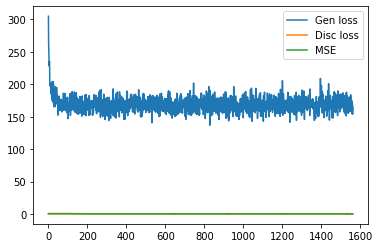

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


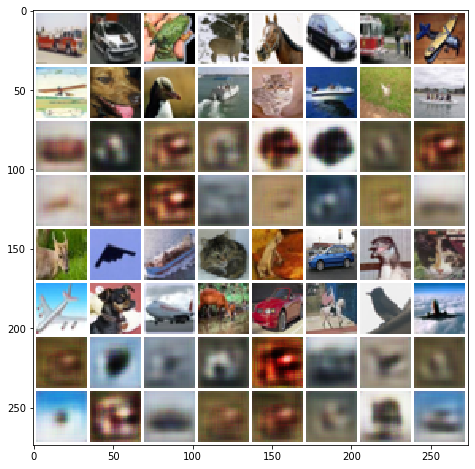

Mean squared dist: 0.0491778
epoch:  2 	 step:0 	 loss: 182.5
epoch:  2 	 step:100 	 loss: 161.2
epoch:  2 	 step:200 	 loss: 172.1
epoch:  2 	 step:300 	 loss: 177.1
epoch:  2 	 step:400 	 loss: 174.4
epoch:  2 	 step:500 	 loss: 181.9
epoch:  2 	 step:600 	 loss: 153.5
epoch:  2 	 step:700 	 loss: 166.3
epoch:  2 	 step:800 	 loss: 163.2
epoch:  2 	 step:900 	 loss: 162.7
epoch:  2 	 step:1000 	 loss: 165.6
epoch:  2 	 step:1100 	 loss: 147.9
epoch:  2 	 step:1200 	 loss: 179.0
epoch:  2 	 step:1300 	 loss: 176.6
epoch:  2 	 step:1400 	 loss: 157.6
epoch:  2 	 step:1500 	 loss: 171.1


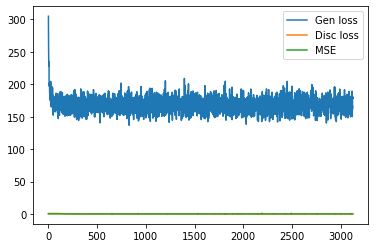

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


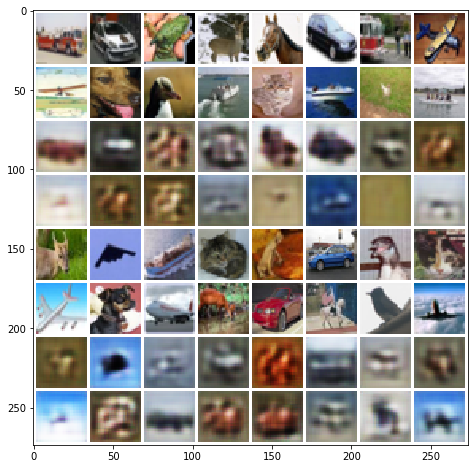

Mean squared dist: 0.045665044
epoch:  3 	 step:0 	 loss: 151.8
epoch:  3 	 step:100 	 loss: 183.7
epoch:  3 	 step:200 	 loss: 185.0
epoch:  3 	 step:300 	 loss: 196.0
epoch:  3 	 step:400 	 loss: 164.9
epoch:  3 	 step:500 	 loss: 171.5
epoch:  3 	 step:600 	 loss: 172.0
epoch:  3 	 step:700 	 loss: 155.6
epoch:  3 	 step:800 	 loss: 167.9
epoch:  3 	 step:900 	 loss: 154.5
epoch:  3 	 step:1000 	 loss: 162.7
epoch:  3 	 step:1100 	 loss: 167.7
epoch:  3 	 step:1200 	 loss: 160.8
epoch:  3 	 step:1300 	 loss: 169.5
epoch:  3 	 step:1400 	 loss: 170.5
epoch:  3 	 step:1500 	 loss: 153.9


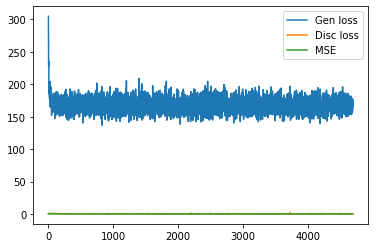

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


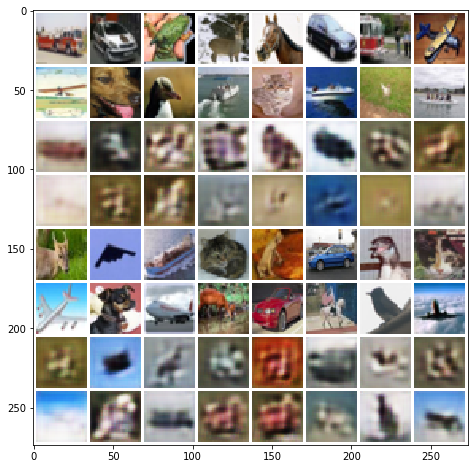

Mean squared dist: 0.046490714
epoch:  4 	 step:0 	 loss: 152.1
epoch:  4 	 step:100 	 loss: 171.5
epoch:  4 	 step:200 	 loss: 171.7
epoch:  4 	 step:300 	 loss: 172.2
epoch:  4 	 step:400 	 loss: 171.6
epoch:  4 	 step:500 	 loss: 177.4
epoch:  4 	 step:600 	 loss: 160.5
epoch:  4 	 step:700 	 loss: 163.6
epoch:  4 	 step:800 	 loss: 171.1
epoch:  4 	 step:900 	 loss: 166.5
epoch:  4 	 step:1000 	 loss: 167.5
epoch:  4 	 step:1100 	 loss: 159.6
epoch:  4 	 step:1200 	 loss: 168.1
epoch:  4 	 step:1300 	 loss: 176.4
epoch:  4 	 step:1400 	 loss: 153.3
epoch:  4 	 step:1500 	 loss: 166.5


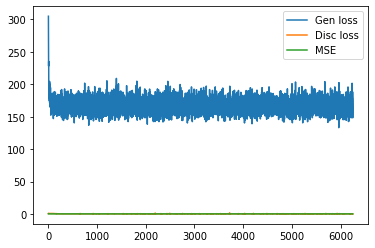

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


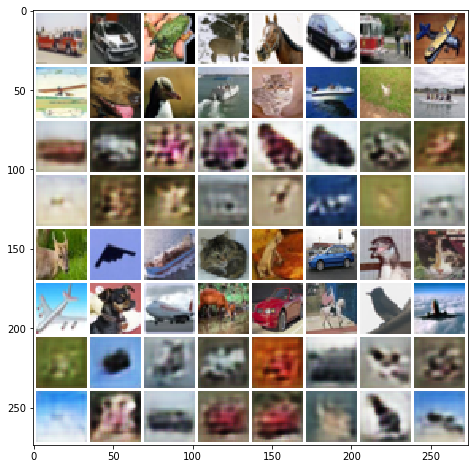

Mean squared dist: 0.047016338
epoch:  5 	 step:0 	 loss: 168.5
epoch:  5 	 step:100 	 loss: 159.4
epoch:  5 	 step:200 	 loss: 161.0
epoch:  5 	 step:300 	 loss: 161.8
epoch:  5 	 step:400 	 loss: 157.5
epoch:  5 	 step:500 	 loss: 188.2
epoch:  5 	 step:600 	 loss: 172.4
epoch:  5 	 step:700 	 loss: 170.7
epoch:  5 	 step:800 	 loss: 151.1
epoch:  5 	 step:900 	 loss: 163.5
epoch:  5 	 step:1000 	 loss: 163.0
epoch:  5 	 step:1100 	 loss: 159.2
epoch:  5 	 step:1200 	 loss: 177.0
epoch:  5 	 step:1300 	 loss: 166.7
epoch:  5 	 step:1400 	 loss: 156.1
epoch:  5 	 step:1500 	 loss: 162.5


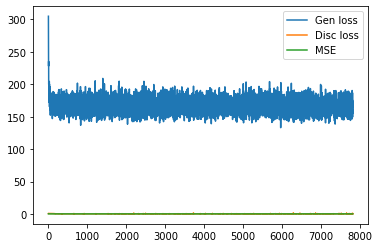

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


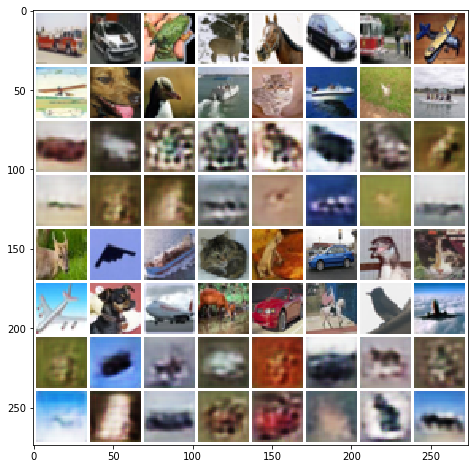

Mean squared dist: 0.04746871
epoch:  6 	 step:0 	 loss: 164.0
epoch:  6 	 step:100 	 loss: 173.1
epoch:  6 	 step:200 	 loss: 171.0
epoch:  6 	 step:300 	 loss: 159.0
epoch:  6 	 step:400 	 loss: 163.7
epoch:  6 	 step:500 	 loss: 168.8
epoch:  6 	 step:600 	 loss: 165.3
epoch:  6 	 step:700 	 loss: 187.5
epoch:  6 	 step:800 	 loss: 178.0
epoch:  6 	 step:900 	 loss: 161.6
epoch:  6 	 step:1000 	 loss: 152.4
epoch:  6 	 step:1100 	 loss: 151.3
epoch:  6 	 step:1200 	 loss: 152.7
epoch:  6 	 step:1300 	 loss: 179.4
epoch:  6 	 step:1400 	 loss: 170.4
epoch:  6 	 step:1500 	 loss: 170.7


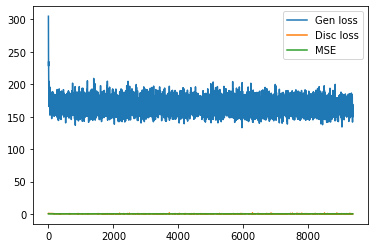

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


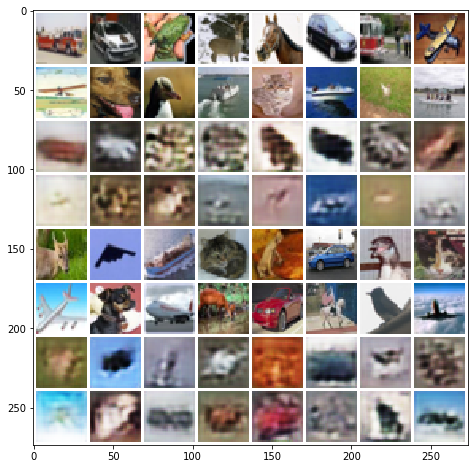

Mean squared dist: 0.046677794
epoch:  7 	 step:0 	 loss: 175.0
epoch:  7 	 step:100 	 loss: 150.5
epoch:  7 	 step:200 	 loss: 152.0
epoch:  7 	 step:300 	 loss: 157.1
epoch:  7 	 step:400 	 loss: 152.3
epoch:  7 	 step:500 	 loss: 161.4
epoch:  7 	 step:600 	 loss: 176.2
epoch:  7 	 step:700 	 loss: 143.3
epoch:  7 	 step:800 	 loss: 171.4
epoch:  7 	 step:900 	 loss: 152.3
epoch:  7 	 step:1000 	 loss: 158.6
epoch:  7 	 step:1100 	 loss: 171.5
epoch:  7 	 step:1200 	 loss: 164.0
epoch:  7 	 step:1300 	 loss: 162.5
epoch:  7 	 step:1400 	 loss: 169.4
epoch:  7 	 step:1500 	 loss: 167.7


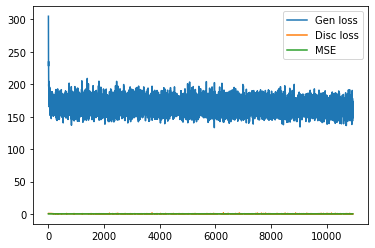

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


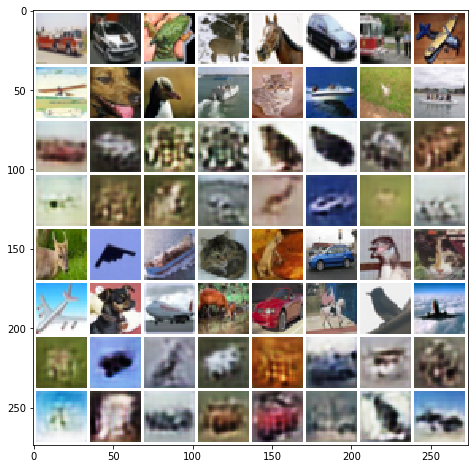

Mean squared dist: 0.04760666
epoch:  8 	 step:0 	 loss: 157.1
epoch:  8 	 step:100 	 loss: 184.3
epoch:  8 	 step:200 	 loss: 157.7
epoch:  8 	 step:300 	 loss: 157.9
epoch:  8 	 step:400 	 loss: 157.3
epoch:  8 	 step:500 	 loss: 154.3
epoch:  8 	 step:600 	 loss: 159.4
epoch:  8 	 step:700 	 loss: 192.7
epoch:  8 	 step:800 	 loss: 167.1
epoch:  8 	 step:900 	 loss: 165.7
epoch:  8 	 step:1000 	 loss: 155.7
epoch:  8 	 step:1100 	 loss: 182.4
epoch:  8 	 step:1200 	 loss: 172.5
epoch:  8 	 step:1300 	 loss: 169.5
epoch:  8 	 step:1400 	 loss: 178.7
epoch:  8 	 step:1500 	 loss: 165.4


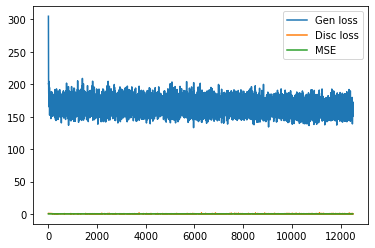

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


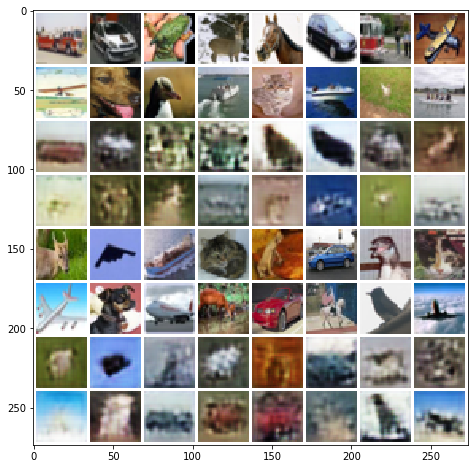

Mean squared dist: 0.04607379
epoch:  9 	 step:0 	 loss: 154.6
epoch:  9 	 step:100 	 loss: 134.6
epoch:  9 	 step:200 	 loss: 149.1
epoch:  9 	 step:300 	 loss: 158.1
epoch:  9 	 step:400 	 loss: 151.5
epoch:  9 	 step:500 	 loss: 155.3
epoch:  9 	 step:600 	 loss: 168.2
epoch:  9 	 step:700 	 loss: 151.6
epoch:  9 	 step:800 	 loss: 164.4
epoch:  9 	 step:900 	 loss: 167.8
epoch:  9 	 step:1000 	 loss: 146.6
epoch:  9 	 step:1100 	 loss: 165.3
epoch:  9 	 step:1200 	 loss: 178.0
epoch:  9 	 step:1300 	 loss: 148.9
epoch:  9 	 step:1400 	 loss: 147.3
epoch:  9 	 step:1500 	 loss: 171.5


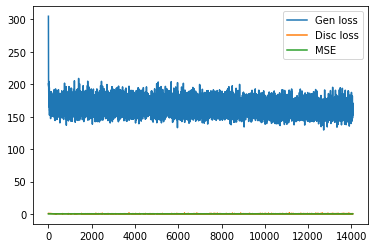

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


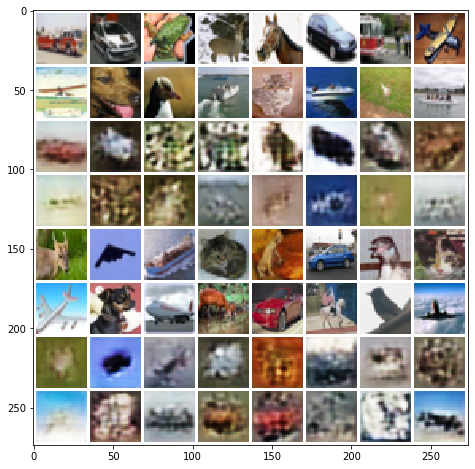

Mean squared dist: 0.04756685
epoch: 10 	 step:0 	 loss: 167.1
epoch: 10 	 step:100 	 loss: 159.5
epoch: 10 	 step:200 	 loss: 171.0
epoch: 10 	 step:300 	 loss: 180.3
epoch: 10 	 step:400 	 loss: 184.7
epoch: 10 	 step:500 	 loss: 169.6
epoch: 10 	 step:600 	 loss: 165.5
epoch: 10 	 step:700 	 loss: 155.0
epoch: 10 	 step:800 	 loss: 152.4
epoch: 10 	 step:900 	 loss: 162.2
epoch: 10 	 step:1000 	 loss: 164.8
epoch: 10 	 step:1100 	 loss: 158.3
epoch: 10 	 step:1200 	 loss: 149.7
epoch: 10 	 step:1300 	 loss: 165.2
epoch: 10 	 step:1400 	 loss: 161.6
epoch: 10 	 step:1500 	 loss: 169.8


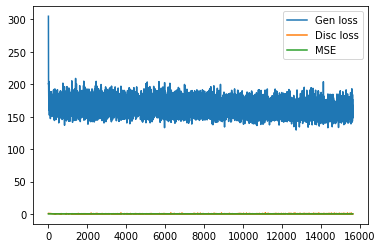

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


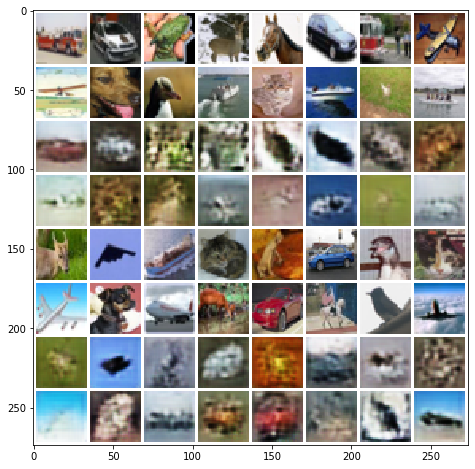

Mean squared dist: 0.046731837
epoch: 11 	 step:0 	 loss: 153.3
epoch: 11 	 step:100 	 loss: 158.9
epoch: 11 	 step:200 	 loss: 163.8
epoch: 11 	 step:300 	 loss: 136.9
epoch: 11 	 step:400 	 loss: 150.2
epoch: 11 	 step:500 	 loss: 152.6
epoch: 11 	 step:600 	 loss: 157.3
epoch: 11 	 step:700 	 loss: 165.2
epoch: 11 	 step:800 	 loss: 161.2
epoch: 11 	 step:900 	 loss: 156.1
epoch: 11 	 step:1000 	 loss: 164.1
epoch: 11 	 step:1100 	 loss: 154.8
epoch: 11 	 step:1200 	 loss: 149.1
epoch: 11 	 step:1300 	 loss: 150.4
epoch: 11 	 step:1400 	 loss: 156.5
epoch: 11 	 step:1500 	 loss: 157.2


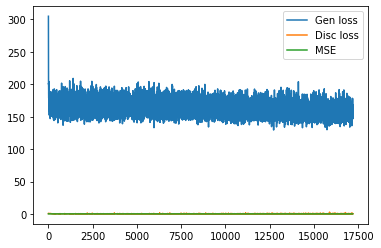

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


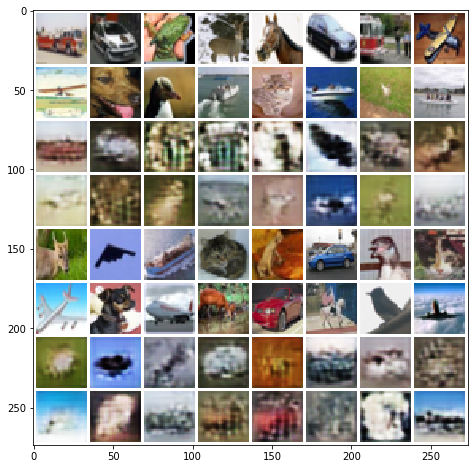

Mean squared dist: 0.049827617
epoch: 12 	 step:0 	 loss: 150.6
epoch: 12 	 step:100 	 loss: 154.0
epoch: 12 	 step:200 	 loss: 156.1
epoch: 12 	 step:300 	 loss: 154.8
epoch: 12 	 step:400 	 loss: 158.2
epoch: 12 	 step:500 	 loss: 147.4
epoch: 12 	 step:600 	 loss: 153.1
epoch: 12 	 step:700 	 loss: 150.5
epoch: 12 	 step:800 	 loss: 155.3
epoch: 12 	 step:900 	 loss: 158.6
epoch: 12 	 step:1000 	 loss: 161.7
epoch: 12 	 step:1100 	 loss: 160.8
epoch: 12 	 step:1200 	 loss: 142.3
epoch: 12 	 step:1300 	 loss: 166.2
epoch: 12 	 step:1400 	 loss: 163.0
epoch: 12 	 step:1500 	 loss: 151.5


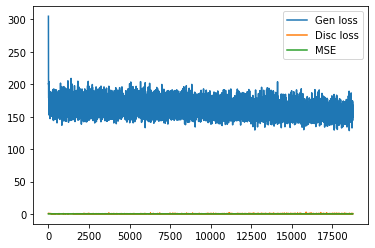

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


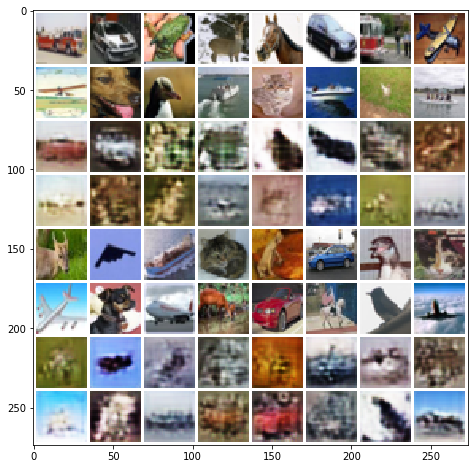

Mean squared dist: 0.04977682
epoch: 13 	 step:0 	 loss: 168.6
epoch: 13 	 step:100 	 loss: 150.3
epoch: 13 	 step:200 	 loss: 153.9
epoch: 13 	 step:300 	 loss: 151.7
epoch: 13 	 step:400 	 loss: 156.5
epoch: 13 	 step:500 	 loss: 146.6
epoch: 13 	 step:600 	 loss: 146.7
epoch: 13 	 step:700 	 loss: 156.4
epoch: 13 	 step:800 	 loss: 153.4
epoch: 13 	 step:900 	 loss: 162.3
epoch: 13 	 step:1000 	 loss: 151.2
epoch: 13 	 step:1100 	 loss: 141.3
epoch: 13 	 step:1200 	 loss: 144.6
epoch: 13 	 step:1300 	 loss: 149.1
epoch: 13 	 step:1400 	 loss: 166.2
epoch: 13 	 step:1500 	 loss: 170.8


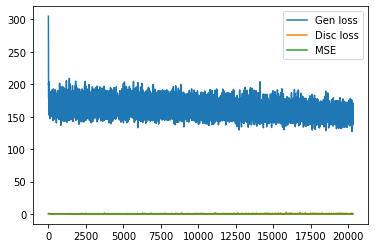

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


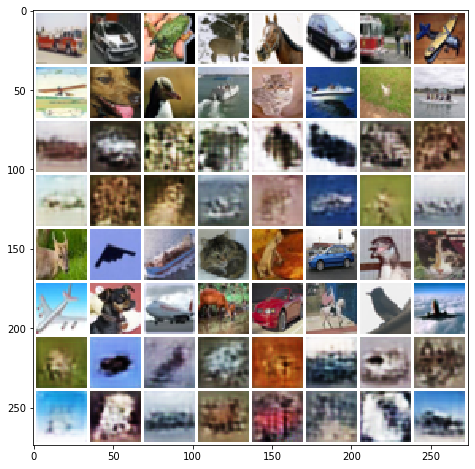

Mean squared dist: 0.04903728
epoch: 14 	 step:0 	 loss: 151.7
epoch: 14 	 step:100 	 loss: 149.0
epoch: 14 	 step:200 	 loss: 143.0
epoch: 14 	 step:300 	 loss: 147.9
epoch: 14 	 step:400 	 loss: 159.0
epoch: 14 	 step:500 	 loss: 160.9
epoch: 14 	 step:600 	 loss: 146.0
epoch: 14 	 step:700 	 loss: 152.9
epoch: 14 	 step:800 	 loss: 152.9
epoch: 14 	 step:900 	 loss: 150.5
epoch: 14 	 step:1000 	 loss: 134.8
epoch: 14 	 step:1100 	 loss: 150.5
epoch: 14 	 step:1200 	 loss: 154.5
epoch: 14 	 step:1300 	 loss: 167.2
epoch: 14 	 step:1400 	 loss: 156.3
epoch: 14 	 step:1500 	 loss: 168.0


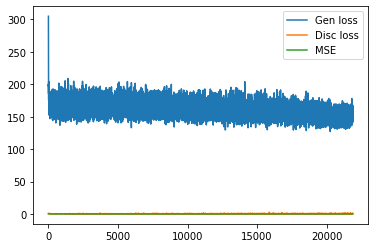

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


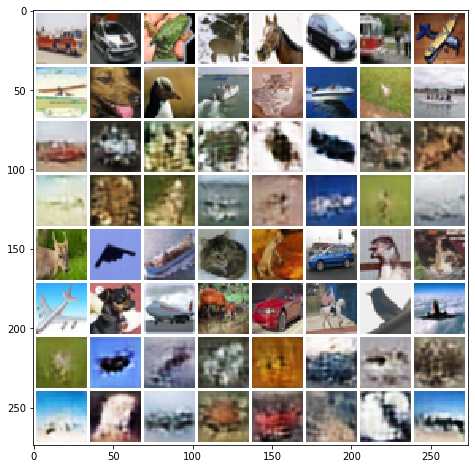

Mean squared dist: 0.049611136
epoch: 15 	 step:0 	 loss: 150.2
epoch: 15 	 step:100 	 loss: 144.3
epoch: 15 	 step:200 	 loss: 143.2
epoch: 15 	 step:300 	 loss: 138.5
epoch: 15 	 step:400 	 loss: 146.1
epoch: 15 	 step:500 	 loss: 142.2
epoch: 15 	 step:600 	 loss: 151.1
epoch: 15 	 step:700 	 loss: 153.0
epoch: 15 	 step:800 	 loss: 151.4
epoch: 15 	 step:900 	 loss: 144.7
epoch: 15 	 step:1000 	 loss: 143.2
epoch: 15 	 step:1100 	 loss: 135.8
epoch: 15 	 step:1200 	 loss: 140.7
epoch: 15 	 step:1300 	 loss: 162.5
epoch: 15 	 step:1400 	 loss: 161.5
epoch: 15 	 step:1500 	 loss: 163.2


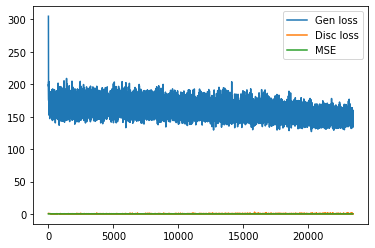

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


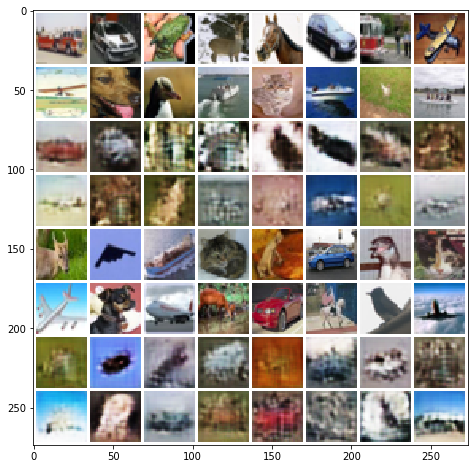

Mean squared dist: 0.04930365
epoch: 16 	 step:0 	 loss: 142.6
epoch: 16 	 step:100 	 loss: 136.3
epoch: 16 	 step:200 	 loss: 149.9
epoch: 16 	 step:300 	 loss: 151.7
epoch: 16 	 step:400 	 loss: 146.8
epoch: 16 	 step:500 	 loss: 147.5
epoch: 16 	 step:600 	 loss: 149.1
epoch: 16 	 step:700 	 loss: 150.1
epoch: 16 	 step:800 	 loss: 140.3
epoch: 16 	 step:900 	 loss: 145.7
epoch: 16 	 step:1000 	 loss: 150.9
epoch: 16 	 step:1100 	 loss: 141.8
epoch: 16 	 step:1200 	 loss: 145.7
epoch: 16 	 step:1300 	 loss: 147.8
epoch: 16 	 step:1400 	 loss: 149.2
epoch: 16 	 step:1500 	 loss: 153.7


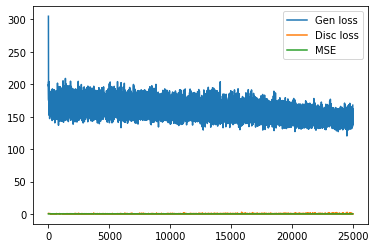

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


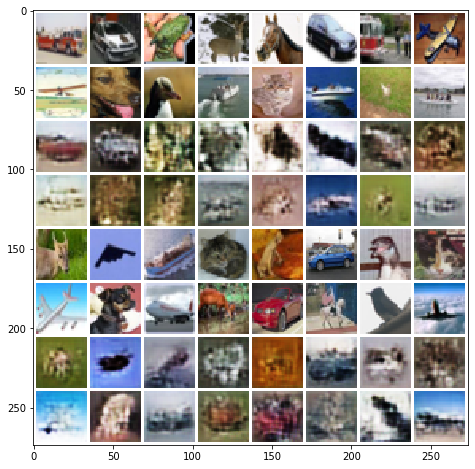

Mean squared dist: 0.049425136
epoch: 17 	 step:0 	 loss: 146.4
epoch: 17 	 step:100 	 loss: 147.4
epoch: 17 	 step:200 	 loss: 146.0
epoch: 17 	 step:300 	 loss: 142.6
epoch: 17 	 step:400 	 loss: 146.8
epoch: 17 	 step:500 	 loss: 150.7
epoch: 17 	 step:600 	 loss: 146.5
epoch: 17 	 step:700 	 loss: 137.1
epoch: 17 	 step:800 	 loss: 145.8
epoch: 17 	 step:900 	 loss: 136.9
epoch: 17 	 step:1000 	 loss: 148.6
epoch: 17 	 step:1100 	 loss: 135.0
epoch: 17 	 step:1200 	 loss: 138.4
epoch: 17 	 step:1300 	 loss: 137.8
epoch: 17 	 step:1400 	 loss: 151.7
epoch: 17 	 step:1500 	 loss: 139.4


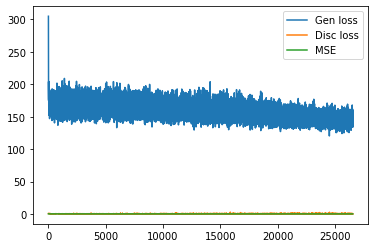

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


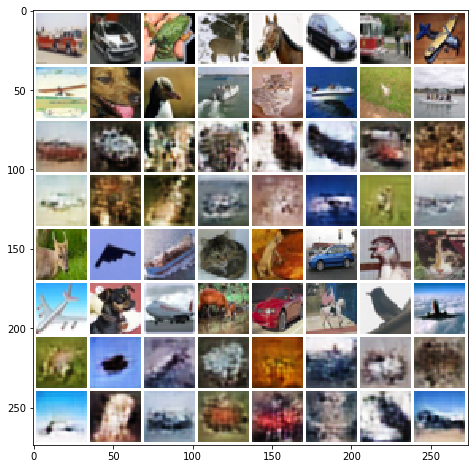

Mean squared dist: 0.052276444
epoch: 18 	 step:0 	 loss: 136.3
epoch: 18 	 step:100 	 loss: 135.0
epoch: 18 	 step:200 	 loss: 152.6
epoch: 18 	 step:300 	 loss: 144.5
epoch: 18 	 step:400 	 loss: 139.2
epoch: 18 	 step:500 	 loss: 157.5
epoch: 18 	 step:600 	 loss: 139.5
epoch: 18 	 step:700 	 loss: 148.2
epoch: 18 	 step:800 	 loss: 147.0
epoch: 18 	 step:900 	 loss: 133.4
epoch: 18 	 step:1000 	 loss: 137.2
epoch: 18 	 step:1100 	 loss: 151.6
epoch: 18 	 step:1200 	 loss: 135.3
epoch: 18 	 step:1300 	 loss: 143.9
epoch: 18 	 step:1400 	 loss: 153.5
epoch: 18 	 step:1500 	 loss: 145.5


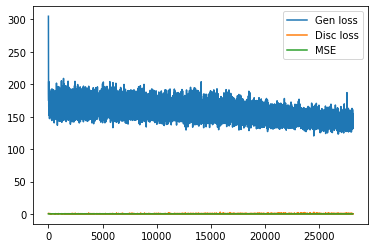

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


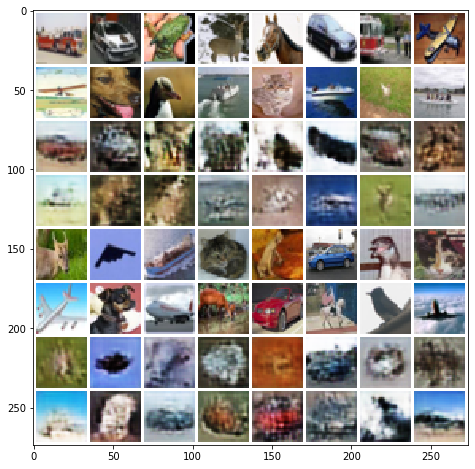

Mean squared dist: 0.050698623
epoch: 19 	 step:0 	 loss: 128.8
epoch: 19 	 step:100 	 loss: 142.3
epoch: 19 	 step:200 	 loss: 156.2
epoch: 19 	 step:300 	 loss: 137.6


In [ ]:
### TRAIN MODEL ###

import time
num_epochs = 250

train_model(gen, disc, g_opt, d_opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/cGAN/Generator64Cifar10_1e3_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))
torch.save(disc_weights, "../cache/cGAN/Discriminator64Cifar10_1e3_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

In [41]:
### LOAD MODEL ####

gen = models.ConvNet(imsize=(6, 32, 32), outsize=imsize, s=64)
disc = ConvDiscriminatorSmall(imsize=(6, 32, 32), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/cGAN/ConvGenerator64Cifar10_1.sd", map_location={'cuda:1': device.__str__()}));
disc.load_state_dict(torch.load("../cache/cGAN/ConvDiscriminator64Cifar10_1.sd", map_location={'cuda:1': device.__str__()}));

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 1024


In [54]:
# Calculate test predictions #

test_images, test_outputs = test_generator(gen, device, dataloader['test'])
print(test_images.shape)

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(8000, 3, 32, 32)


In [55]:
# Benchmark test predictions #

benchmark(pred=test_outputs[:1024], true=test_images[:1024], check_all=True)

Signal error:
  MSE: 0.04784483043818, std: 0.030436912456593343
  MAE: 0.16167194291301712, std: 0.056309947828955424
  SSIM: 0.2612542470583443, std: 0.15232844973647816
  FASI-MSE: 0.04771832995265868, std: 0.028917165582766562
  FASI-MAE: 0.1621688243412791, std: 0.05339144363439821
  COCO-MSE: 0.03316329446295094, std: 0.017152022430788436

Magnitude error:
  MSE Magnitude: 11.078729753763241, std: 6.41725450594491

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


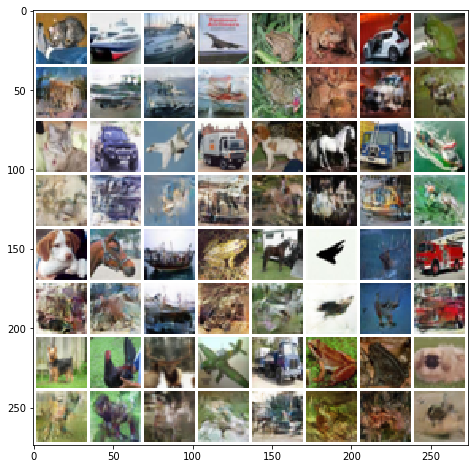

In [56]:
# Plot test predictions #

to_plot = np.stack([test_images[:32].reshape(4, 8*3, 32, 32), 
                    test_outputs[:32].reshape(4, 8*3, 32, 32)], axis=1).reshape(-1, 3, 32, 32)
           
plot_grid(torch.Tensor(to_plot), figsize=(8,8), file="../out/cgan/cifar10/ConvGenerator64Cifar10_2.png")

## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | Type | Loss | Size | epochs | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Conv | log GAN + 1e3 * MAE | 64 | 250 | 0.05277 | 0.1691 | 0.2404 | 0.05412 | 0.1723 | 0.03650 | 11.92
| 2 | Conv | log GAN + 1e3 * MAE | 128 | 250| 0.04784 | 0.1617 | 0.2612 | 0.04772 | 0.1622 | 0.03316 | 11.08


In [31]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft**2, -1) + 1e-16)
    return mags

In [32]:
# Latent z optimization

def genopt(sample_magnitudes, gen, disc, device, init_x=None, max_steps=5000, max_loss=0.0, mue=1.0, lr=1.0):
    
    if disc is not None:
        disc.to(device)
        disc.eval()
    gen.to(device)
    gen.eval()
    
    if init_x is None:
        z = torch.randn((sample_magnitudes.shape), requires_grad=True, device=device)
    else:
        raise NotImplementedError
    
    optimizer = optim.Adam([z], lr=lr)
    
    losses = []
    last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
    
    for i in range(max_steps):
        magnitudes = calc_mags(last_out)

        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=(1, 2, 3))
        reconstruction = torch.sum(mse_all)
        #adversarial = -torch.mean(torch.log(disc(torch.cat([last_out, sample_magnitudes], dim=1))))
        #loss = reconstruction + mue * adversarial
        loss = reconstruction + mue * torch.mean(z ** 2)
        
        if loss < max_loss:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
        
        losses.append(loss.item())
    
    return last_out.detach(), losses, mse_all


/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Batch 1/1 finished


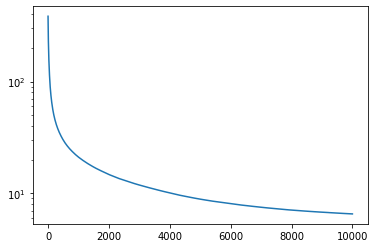

In [57]:
### Latent z optimization ###

num_batches = 1
batch_size = 32
max_steps = 10000
max_loss = 0.0
mue = 0.0
lr = 1.0

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    

    cur_out_results, cur_loss, cur_mse_all = genopt(sample_magnitudes=test_magnitudes, gen=gen, disc=None, device=device,
                                          max_steps=max_steps, max_loss=max_loss, mue=mue, lr=lr)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [58]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_Cifar10/cgan_original_2.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_Cifar10/cgan_2.p", "wb"))

In [43]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Cifar10/cgan_original_1_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Cifar10/cgan_1_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


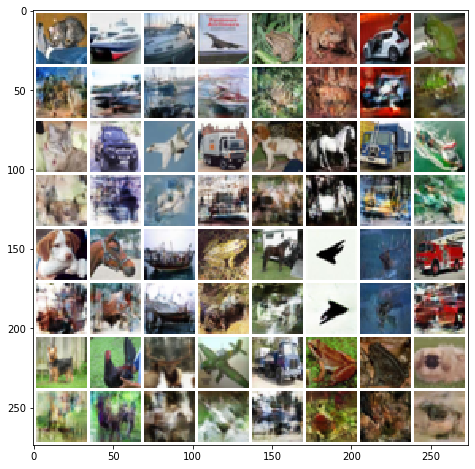

Signal error:
  MSE: 0.07348841052716643, std: 0.044103479846566436
  MAE: 0.20135359048309098, std: 0.07222206863696995
  SSIM: 0.17635085809658066, std: 0.15874141470558265
  FASI-MSE: 0.06421087920232646, std: 0.03928566360745179
  FASI-MAE: 0.18849332291434115, std: 0.0712645302368312
  COCO-MSE: 0.03721080323375915, std: 0.019501319753066314

Magnitude error:
  MSE Magnitude: 0.20400334210962073, std: 0.13100556719952827

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [59]:
print("Output under minimized magnitude distance:")
to_plot = np.stack([out_original[:32].reshape(4, 8*3, 32, 32),
                    out_results[:32].reshape(4, 8*3, 32, 32)], axis=1).reshape(-1, 3, 32, 32)
plot_grid(to_plot, figsize=(8, 8), file="../out/cgan/cifar10/ConvGenerator64Cifar10_2_10000latentSteps.png")

benchmark(pred=out_results, true=out_original, check_all=True)

## Evaluation for different z optimizations (64 samples)

| Nr Type | iterations | mue | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 0.0 | 1.0 | 0.06577 | 0.1897 | 0.2097 | 0.06070 | 0.1811 | 0.03583 | 0.3561
| 2 | 10000 | 0.0 | 1.0 | 0.07349 | 0.2014 | 0.1764 | 0.06421 | 0.1885 | 0.03721 | 0.2040

## Final Evaluation (1024 samples)

| Nr Type | iterations | mue | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 0.0 | 1.0 | 0.05889 | 0.1772 | 0.2430 | 0.0515 | 0.1662 | 0.03216 | 0.3228
